### Import Libraries

In [21]:
import yfinance as yf
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from pypfopt import plotting
import cvxpy 
import pypfopt.plotting as plotting
from datetime import datetime, timedelta
from fredapi import Fred
from dotenv import load_dotenv
import os
load_dotenv()
#import warnings
# warnings.filterwarnings("ignore")

True

In [7]:
API_KEY = os.getenv("API_KEY")
fred = Fred(api_key=API_KEY)
cpi_data = fred.get_series('CPIAUCSL')  # This is the FRED ID for CPI

start_date = "2015-01-01"
end_date = "2025-05-01"


# Optional: convert to DataFrame
cpi_df = cpi_data.to_frame(name='CPI')
cpi_df.index.name = 'Date'
cpi_df = cpi_df[(cpi_df.index >= start_date) & (cpi_df.index <= end_date)]
# cpi_normalized = cpi_df / cpi_df.iloc[0]

print(cpi_df)

                CPI
Date               
2015-01-01  234.747
2015-02-01  235.342
2015-03-01  235.976
2015-04-01  236.222
2015-05-01  237.001
...             ...
2024-12-01  317.603
2025-01-01  319.086
2025-02-01  319.775
2025-03-01  319.615
2025-04-01  320.321

[124 rows x 1 columns]


In [17]:
#USCAD currency, gold, S&P 500, long term tradable treasury bond, bitcoin
# tickers = ['USDCAD=X', 'GLD', '^GSPC', 'TLT', 'BTC-USD']
tickers = ['GLD', '^GSPC', 'BTC-USD']

daily_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    daily_data[ticker] = data['Adj Close']

daily_data.rename(columns={'GLD': 'Gold', '^GSPC': 'SP500', 'BTC-USD': 'Bitcoin'}, inplace=True)

yearly_data = daily_data.resample('YE').last()


adj_close_df = daily_data.resample('MS').first()
print(daily_data)

print(adj_close_df)





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  Gold        SP500       Bitcoin
Date                                             
2015-01-02  114.080002  2058.199951    315.032013
2015-01-05  115.800003  2020.579956    274.473999
2015-01-06  117.120003  2002.609985    286.188995
2015-01-07  116.430000  2025.900024    294.337006
2015-01-08  115.940002  2062.139893    283.348999
...                ...          ...           ...
2025-04-24  308.070007  5484.770020  93943.796875
2025-04-25  304.730011  5525.209961  94720.500000
2025-04-28  309.070007  5528.750000  94978.750000
2025-04-29  306.059998  5560.830078  94284.789062
2025-04-30  303.769989  5569.060059  94207.312500

[2597 rows x 3 columns]
                  Gold        SP500        Bitcoin
Date                                              
2015-01-01  114.080002  2058.199951     315.032013
2015-02-01  122.419998  2020.849976     238.229004
2015-03-01  115.680000  2117.389893     275.670013
2015-04-01  115.599998  2059.689941     247.272003
2015-05-01  113.080

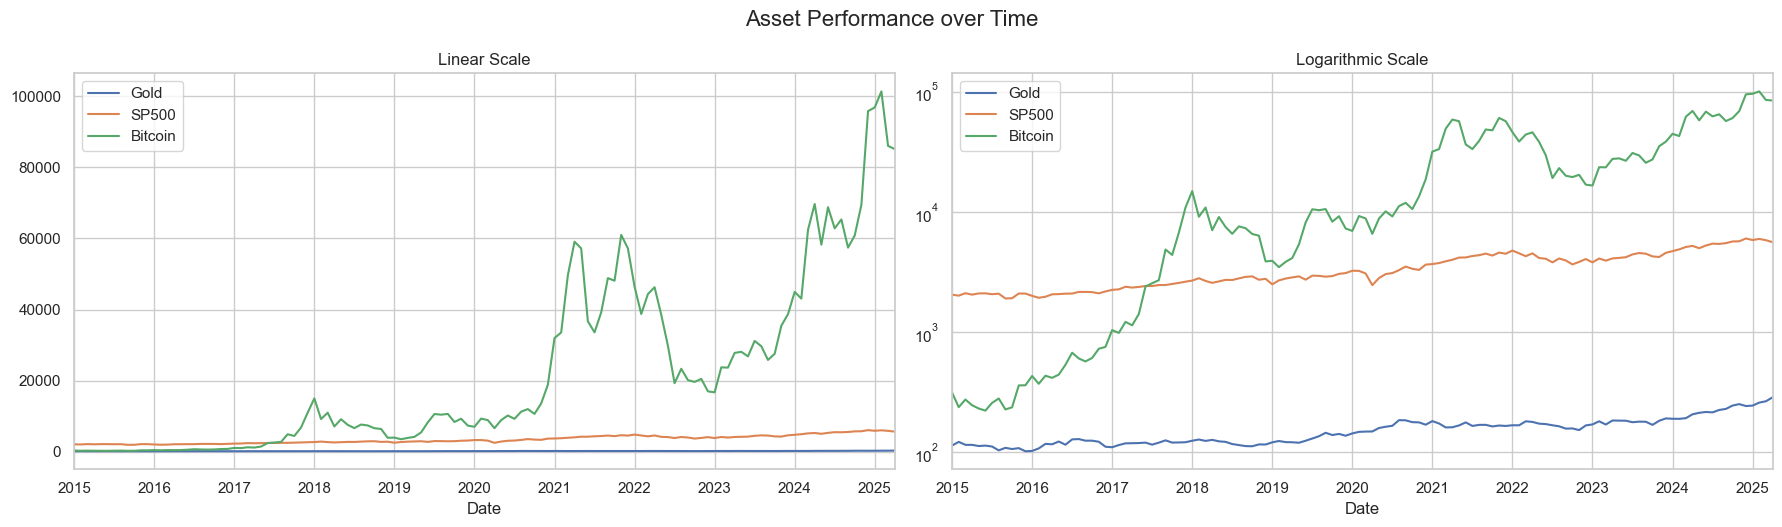

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
adj_close_df[['Gold', 'SP500', 'Bitcoin']].plot(ax=axes[0])
axes[0].set_title('Linear Scale')
adj_close_df[['Gold', 'SP500', 'Bitcoin']].plot(ax=axes[1], logy=True)
axes[1].set_title('Logarithmic Scale')
# plt.grid(True)
# plt.show()

# adj_close_df[['Gold', 'SP500', 'Bitcoin']].plot(figsize=(12,6), title="Asset Performance over Time")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

plt.tight_layout()
plt.suptitle('Asset Performance over Time', fontsize=16, y=1.05)
plt.show()

### Calculate Returns

In [12]:
#log of row divided by previous row
asset_monthly_returns = adj_close_df.pct_change().dropna()

asset_annual_returns = yearly_data.pct_change().dropna()


cpi_returns = cpi_df.pct_change().dropna()


# print(asset_returns)
# print(cpi_returns)

# assets_normalized = adj_close_df / adj_close_df.iloc[0]
monthly_returns = pd.merge(cpi_returns, asset_monthly_returns, how='inner', on='Date')


print(monthly_returns)

                 CPI      Gold     SP500   Bitcoin
Date                                              
2015-02-01  0.002535  0.073107 -0.018147 -0.243794
2015-03-01  0.002694 -0.055056  0.047772  0.157164
2015-04-01  0.001042 -0.000692 -0.027251 -0.103015
2015-05-01  0.003298 -0.021799  0.023596 -0.061442
2015-06-01  0.002768  0.008136  0.001632 -0.039439
...              ...       ...       ...       ...
2024-12-01  0.003647 -0.035767  0.055570  0.379705
2025-01-01  0.004669  0.008133 -0.029535  0.010656
2025-02-01  0.002159  0.059164  0.021474  0.046637
2025-03-01 -0.000500  0.026160 -0.024163 -0.151271
2025-04-01  0.002209  0.078091 -0.037036 -0.010416

[123 rows x 4 columns]


              CPI      Gold     SP500   Bitcoin
CPI      1.000000 -0.025325  0.201150 -0.010580
Gold    -0.025325  1.000000  0.042804  0.101858
SP500    0.201150  0.042804  1.000000  0.325864
Bitcoin -0.010580  0.101858  0.325864  1.000000


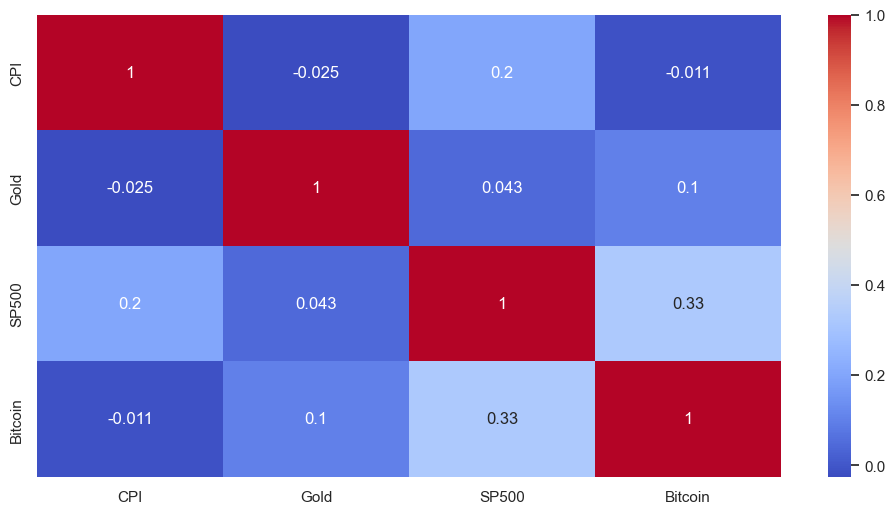

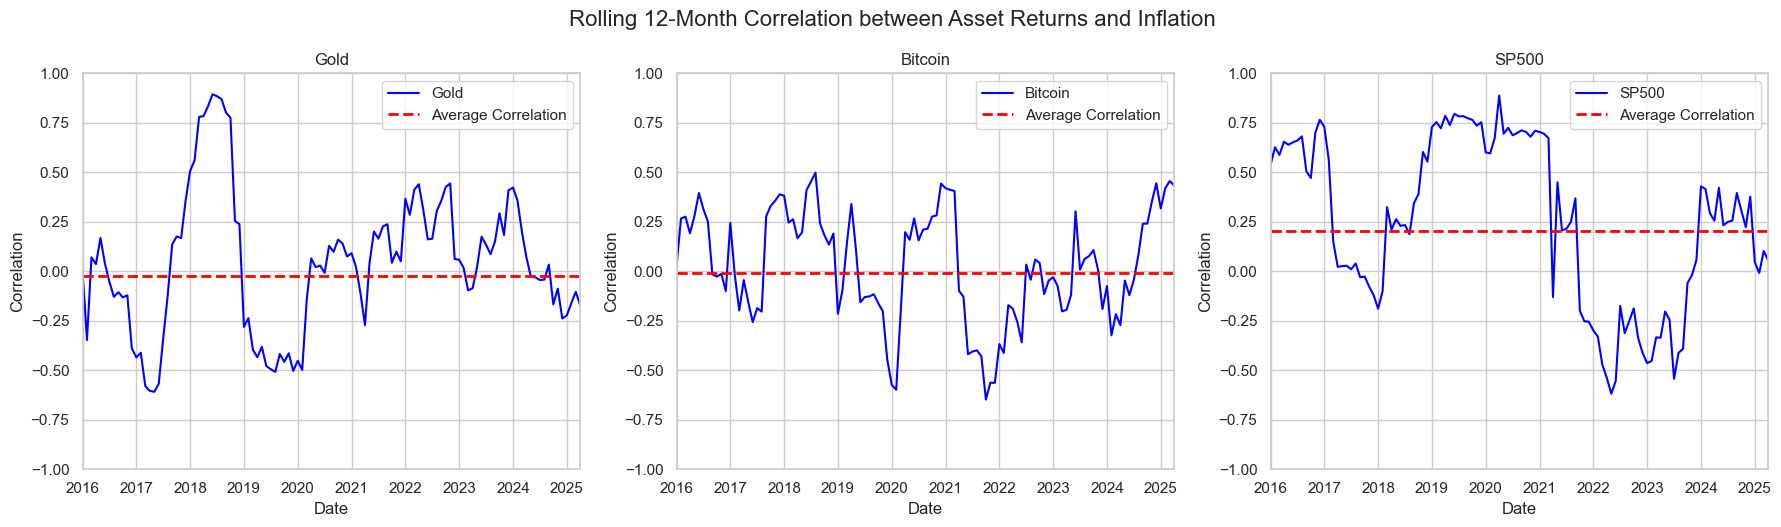

In [40]:
corr_coefs = monthly_returns[['Gold', 'SP500', 'Bitcoin']].corrwith(monthly_returns['CPI'])
print(monthly_returns[['CPI', 'Gold', 'SP500', 'Bitcoin']].corr())
# returns[['CPI', 'Gold', 'SP500', 'Bitcoin']].plot(figsize=(12,6), title="Asset Returns vs Inflation")

plt.figure(figsize=(12,6))

sns.heatmap(monthly_returns[['CPI', 'Gold', 'SP500', 'Bitcoin']].corr(), cmap='coolwarm', annot=True)
# Plot rolling correlations with labels
rolling_corr_gold = monthly_returns['Gold'].rolling(window=12).corr(monthly_returns['CPI']).dropna()
rolling_corr_bitcoin = monthly_returns['Bitcoin'].rolling(window=12).corr(monthly_returns['CPI']).dropna()
rolling_corr_sp500 = monthly_returns['SP500'].rolling(window=12).corr(monthly_returns['CPI']).dropna()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gold vs CPI
rolling_corr_gold.plot(ax=axes[0], label='Gold', color='blue')
axes[0].axhline(y=corr_coefs['Gold'], color='red', linestyle='--', linewidth=2, label='Average Correlation')
axes[0].set_ylabel('Correlation')
axes[0].set_title('Gold')
axes[0].legend()
axes[0].set_ylim(-1, 1)

# Bitcoin vs CPI
rolling_corr_bitcoin.plot(ax=axes[1], label='Bitcoin', color='blue')
axes[1].axhline(y=corr_coefs['Bitcoin'], color='red', linestyle='--', linewidth=2, label='Average Correlation')
axes[1].set_ylabel('Correlation')
axes[1].set_title('Bitcoin')
axes[1].legend()
axes[1].set_ylim(-1, 1)

# S&P 500 vs CPI
rolling_corr_sp500.plot(ax=axes[2], label='SP500', color='blue')
axes[2].axhline(y=corr_coefs['SP500'], color='red', linestyle='--', linewidth=2, label='Average Correlation')
axes[2].set_ylabel('Correlation')
axes[2].set_title('SP500')
axes[2].legend()
axes[2].set_ylim(-1, 1)
# plt.title('Rolling 12-Month Correlation between Gold and CPI')
# plt.xlabel('Date')
# plt.ylabel('Correlation')

plt.tight_layout()
plt.suptitle('Rolling 12-Month Correlation between Asset Returns and Inflation', fontsize=16, y=1.05)
plt.show()

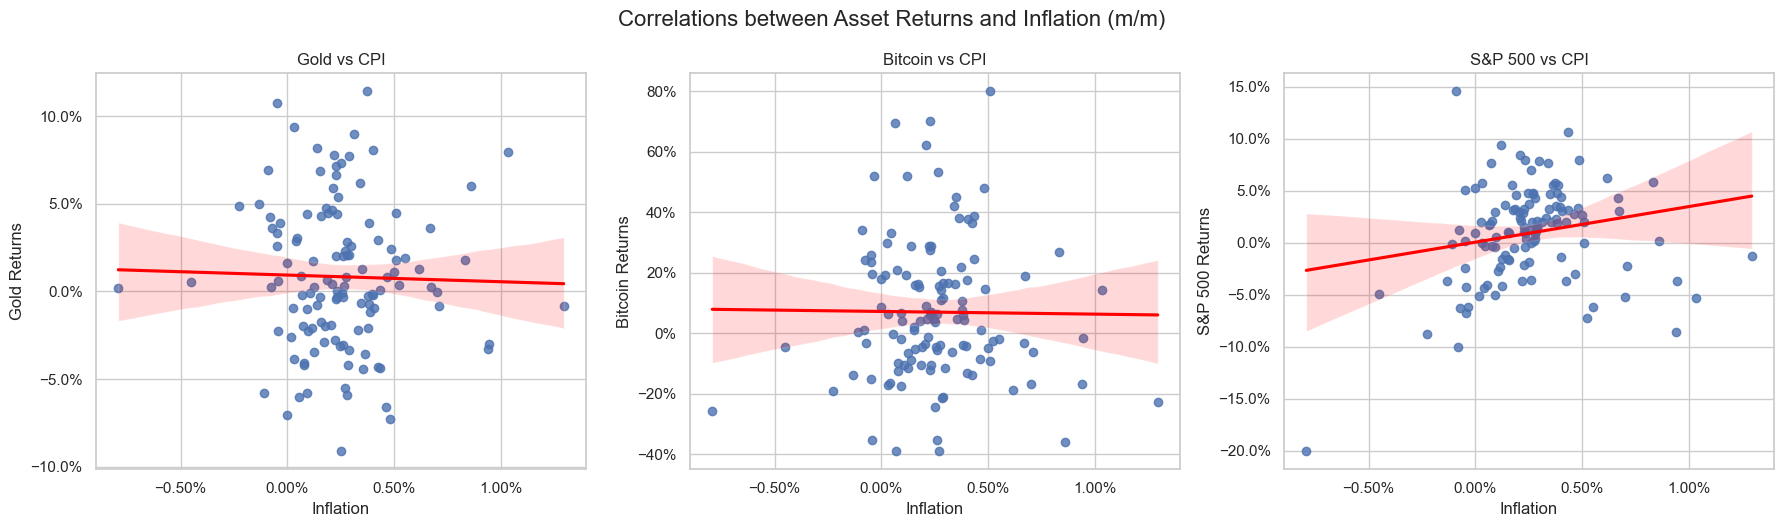

In [13]:
# Set style
sns.set_theme(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter + regression for Gold
sns.regplot(x=monthly_returns['CPI'], y=monthly_returns['Gold'], ax=axes[0], line_kws={'color': 'red'})
axes[0].set_title('Gold vs CPI')
axes[0].set_xlabel('Inflation')
axes[0].set_ylabel('Gold Returns')

# Scatter + regression for Bitcoin
sns.regplot(x=monthly_returns['CPI'], y=monthly_returns['Bitcoin'], ax=axes[1], line_kws={'color': 'red'})
axes[1].set_title('Bitcoin vs CPI')
axes[1].set_xlabel('Inflation')
axes[1].set_ylabel('Bitcoin Returns')

# Scatter + regression for S&P 500
sns.regplot(x=monthly_returns['CPI'], y=monthly_returns['SP500'], ax=axes[2], line_kws={'color': 'red'})
axes[2].set_title('S&P 500 vs CPI')
axes[2].set_xlabel('Inflation')
axes[2].set_ylabel('S&P 500 Returns')

# Format axes as percentages
for ax in axes:
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.suptitle('Correlations between Asset Returns and Inflation (m/m)', fontsize=16, y=1.05)
plt.show()

### Forecast Expected Returns

In [16]:
mu2 = expected_returns.mean_historical_return(daily_data)
print(mu2)

Gold       0.099736
SP500      0.101448
Bitcoin    0.739102
dtype: float64


### Covariance Matrix

In [18]:
cov_matrix = risk_models.sample_cov(daily_data)
print(cov_matrix)

             Gold     SP500   Bitcoin
Gold     0.020415  0.001413  0.008752
SP500    0.001413  0.033287  0.027558
Bitcoin  0.008752  0.027558  0.467164


### Efficient Frontier

In [19]:
ef = EfficientFrontier(mu2, cov_matrix)
ef.max_sharpe()


OrderedDict([('Gold', 0.5723578297811487),
             ('SP500', 0.234835008608763),
             ('Bitcoin', 0.1928071616100884)])

In [20]:
ef.portfolio_performance(verbose=True)

Expected annual return: 22.3%
Annual volatility: 17.5%
Sharpe Ratio: 1.28


(np.float64(0.22341216575533857),
 np.float64(0.17520585358989546),
 np.float64(1.275140990884241))

Expected annual return: 22.3%
Annual volatility: 17.5%
Sharpe Ratio: 1.28


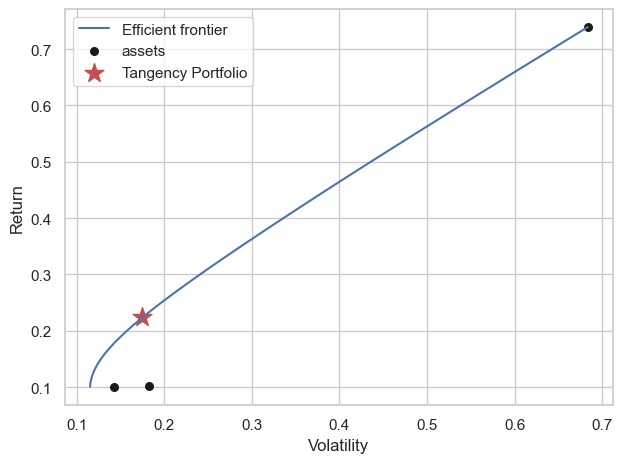

In [22]:
ef_plot = EfficientFrontier(mu2, cov_matrix, weight_bounds=(0, 1))
weights_plot = ef_plot.max_sharpe()
ef_plot.portfolio_performance(verbose=True)
ef_constraints = EfficientFrontier(mu2, cov_matrix, weight_bounds=(0, 1))
ef_constraints.add_constraint(lambda x: cvxpy.sum(x) == 1)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_constraints, ax=ax, show_assets=True)

ax.scatter(ef_plot.portfolio_performance()[1], ef_plot.portfolio_performance()[0], color='r', marker='*', s=200, label="Tangency Portfolio")
ax.legend()

plt.show()